In [ ]:
from datasets.vc_clothes_dataset import VCClothesDatasetFaces, build_transforms
from datasets.face_dataset import FaceDataset
from models.face_detector import FaceDetector
from models.face_feature_extractor import FaceFeatureExtractor

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

c:\25Z\GSN\projekt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_ROOT = "./data/vc_clothes"
DEVICE = "cpu"
BATCH_SIZE = 32
LR = 0.00035
EPOCHS = 3

print(f"Device: {DEVICE}")

Device: cpu


In [4]:
# Tworzenie transformacji
train_transforms = build_transforms(if_normalize=False)
val_transforms = build_transforms(if_normalize=False)

# Instancja datasetu treningowego
# VC-Clothes ma 9,449 obrazów treningowych [cite: 194]
train_set = VCClothesDatasetFaces(DATA_ROOT, mode="train", transform=train_transforms, save_faces=True)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)


gallery_set = VCClothesDatasetFaces(DATA_ROOT, mode="gallery", transform=train_transforms, save_faces=True)
gallery_loader = DataLoader(gallery_set, batch_size=32, shuffle=True, num_workers=4)

# Instancja datasetu testowego (Query)
# VC-Clothes ma 1,020 obrazów query [cite: 194]
query_set = VCClothesDatasetFaces(DATA_ROOT, mode="query", transform=val_transforms, save_faces=True)
test_loader = DataLoader(query_set, batch_size=32, shuffle=False, num_workers=4)

print("\nPrzykładowy element batcha:")
imgs, pids, cams, clothes, faces, paths = next(iter(train_loader))
print(f"Shape obrazów: {imgs.shape}")  # Oczekiwane [32, 3, 256, 128]
print(f"PIDs: {pids}")
print(f"Clothes IDs: {clothes}")

Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3

Przykładowy element batcha:
Shape obrazów: torch.Size([32, 3, 256, 128])
PIDs: tensor([ 40, 103, 253,  86, 204, 146, 102,  86, 250,  56,  74,  25, 118,  98,
        147, 192, 139,  21, 208,  21,  72,  39, 127, 139,  61,  11,  85, 144,
        176, 186, 132, 250])
Clothes IDs: tensor([3, 3, 1, 1, 1, 1, 3, 2, 3, 3, 1, 1, 1, 3, 1, 2, 3, 1, 1, 3, 1, 2, 1, 1,
        2, 1, 1, 3, 1, 2, 1, 2])


In [5]:
imgs_batch, pids_batch, cams_batch, clothes_batch, faces_batch, paths_batch = next(iter(train_loader))

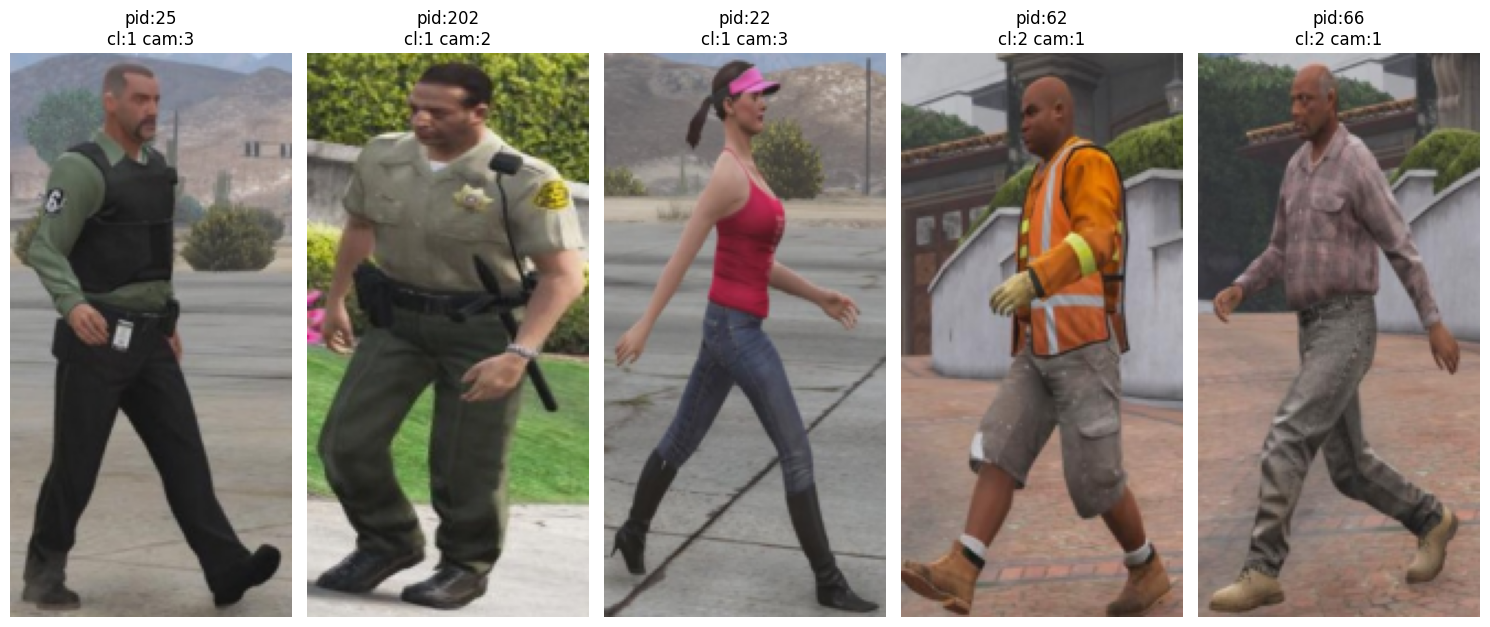

In [ ]:
N = 5

fig, axes = plt.subplots(1, N, figsize=(N * 3, 8))
if N == 1:
    axes = [axes]

for i in range(N):
    ax = axes[i]
    img = imgs_batch[i]
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(
        f"pid:{int(pids_batch[i])}\ncl:{int(clothes_batch[i])} cam:{int(cams_batch[i])}"
    )

plt.tight_layout()
plt.show()

In [8]:
detector = FaceDetector(device=DEVICE, confidence_threshold=0.5)

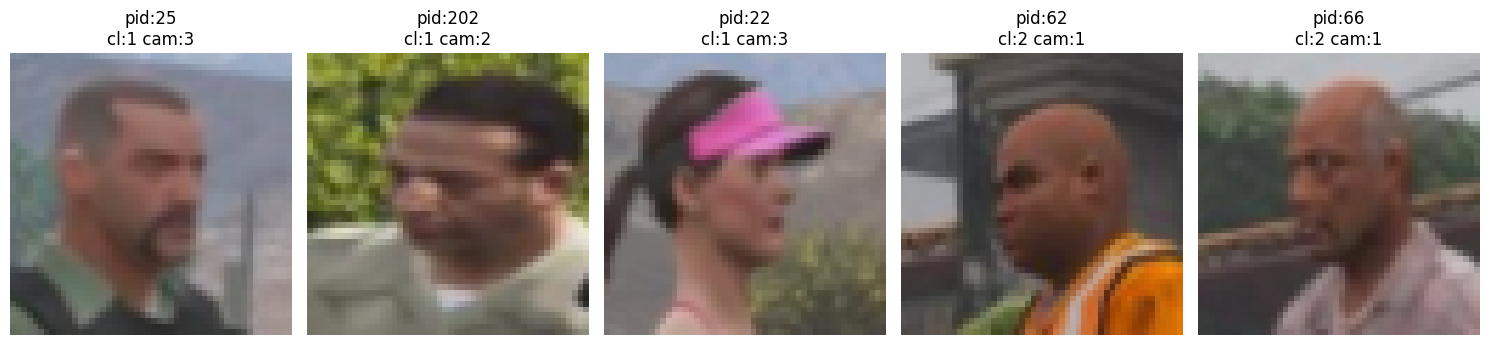

In [ ]:
N = min(5, imgs_batch.size(0))

fig, axes = plt.subplots(1, N, figsize=(N * 3, 5))
if N == 1:
    axes = [axes]

for i in range(N):
    ax = axes[i]
    img = imgs_batch[i]
    img = img.permute(1, 2, 0).numpy()
    img = transforms.ToPILImage()(img)
    face_tensor = detector.get_face_tensor(img)
    if face_tensor is None:
        ax.set_title("Brak wykrytej twarzy")
        ax.axis("off")
        continue
    face = face_tensor
    face = face.permute(1, 2, 0).numpy()
    face = transforms.ToPILImage()(face)
    ax.imshow(face)
    ax.axis("off")
    ax.set_title(
        f"pid:{int(pids_batch[i])}\ncl:{int(clothes_batch[i])} cam:{int(cams_batch[i])}"
    )

plt.tight_layout()
plt.show()

In [15]:
import os
from tqdm import tqdm
from PIL import Image
import torch
from pathlib import Path
from torchvision.utils import save_image


mapping = {
    "train": "train_faces",
    "gallery": "gallery_faces",
    "query": "query_faces"
}


def save_face_dataset(dataset: Dataset):
    processed = 0
    detected = 0

    for img, pid, camid, clothid, face, path in tqdm(dataset):
        processed += 1

        img_tmp = transforms.ToPILImage()(img)

        # Detekcja twarzy (zwraca Tensor na GPU lub None)
        with torch.no_grad():  # Detektor nie jest trenowany!
            face_tensor = detector.get_face_tensor(img_tmp)

        face_path = path
        for old, new in mapping.items():
            face_path = face_path.replace(old, new)

        path = Path(face_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        
        if face_tensor is not None:
            detected += 1

            face = face_tensor.permute(1, 2, 0).numpy()

            to_pil = transforms.ToPILImage()
            face_pil = to_pil(face)
            
            face_pil.save(face_path)
        else:
            w, h = img_tmp.size
            
            # Wycinamy górny fragment środka
            # left, upper, right, lower
            face_img = img_tmp.crop((
                w * 0.25,  # Zacznij od 25% szerokości
                0,         # Od samej góry
                w * 0.75,  # Do 75% szerokości
                h * 0.10   # Bierzemy górne 10% wysokości
            ))
            face_img = face_img.resize((50, 50))
            face_img.save(face_path)
            


    print(f"Przetworzono obrazów: {processed}, zdetektowano twarzy: {detected}")

In [16]:
save_face_dataset(train_set)

100%|██████████| 9449/9449 [05:25<00:00, 29.01it/s]

Przetworzono obrazów: 9449, zdetektowano twarzy: 6819


In [18]:
save_face_dataset(gallery_set)

100%|██████████| 8591/8591 [04:09<00:00, 34.50it/s]

Przetworzono obrazów: 8591, zdetektowano twarzy: 6157


In [19]:
save_face_dataset(query_set)

100%|██████████| 1020/1020 [00:32<00:00, 31.58it/s]

Przetworzono obrazów: 1020, zdetektowano twarzy: 743


In [20]:
print("\nStatystyki detekcji twarzy na zbiorze VC-Clothes:")
print(f"Na zbiorze train: {6819/9449:2f}")
print(f"Na zbiorze gallery: {6157/8591:2f}")
print(f"Na zbiorze query: {743/1020:2f}")
print(f"Łącznie: {(6819+6157+743)/(9449+8591+1020):2f}")


Statystyki detekcji twarzy na zbiorze VC-Clothes:
Na zbiorze train: 0.721664
Na zbiorze gallery: 0.716680
Na zbiorze query: 0.728431
Łącznie: 0.719780


In [ ]:
query_dataset = FaceDataset("./data/vc_clothes_faces", mode="query")

Znaleziono 743 obrazów w ./data/vc_clothes_faces/query_faces
Znaleziono 253 unikalnych klas (PIDów).
Załadowano FaceDataset (query): 743 obrazów, 253 klas.
